In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [12]:
baseline_vars_df = pd.read_csv('baseline_data.csv')

In [24]:
print(baseline_vars_df["high"].values)

[1.11 1.24 1.11 ... 1.4  1.4  1.4 ]


In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [25]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assume baseline_vars_df is your DataFrame with columns: "State", "asset_quality", "profitability", "high"
selected_vars = ["asset_quality", "profitability", "low"]
X = baseline_vars_df[selected_vars].values
states = baseline_vars_df["State"].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use PCA with whitening to obtain a whitened representation
pca = PCA(whiten=True, random_state=42)
X_whitened = pca.fit_transform(X_scaled)

# Run K-means clustering on the whitened data (this now uses the PCA-based whitening which is robust)
k = 4  # choose appropriate number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_whitened)

# For each state, compute Euclidean distance in the whitened space to its assigned cluster centroid
distances = []
for i in range(len(states)):
    centroid = kmeans.cluster_centers_[clusters[i]]
    d = np.linalg.norm(X_whitened[i] - centroid)
    distances.append(d)

# Use negative distances as the similarity (G) score (higher means more similar to the centroid)
kmeans_mahalanobis_scores = pd.DataFrame({
    "State": states,
    "kmeans_mahalanobis_score": -np.array(distances)
})

print("K-Means (Mahalanobis via PCA Whitening) G-Scores:")
print(kmeans_mahalanobis_scores.sort_values("kmeans_mahalanobis_score", ascending=False).head(10))


d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


K-Means (Mahalanobis via PCA Whitening) G-Scores:
          State  kmeans_mahalanobis_score
125    arkansas                 -0.046610
124    arkansas                 -0.046610
123    arkansas                 -0.046610
122    arkansas                 -0.046610
1832  wisconsin                 -0.057055
1834  wisconsin                 -0.057055
1833  wisconsin                 -0.057055
1835  wisconsin                 -0.057055
687       maine                 -0.062837
685       maine                 -0.062837


In [22]:
print(baseline_vars_df.isna().sum())


year               0
qtr                0
state_fips         0
low                0
high             153
FIPS               0
State              0
YearQuarter        0
profitability      0
asset_quality      0
dtype: int64


In [21]:
# Check if there are any NaN values in X_scaled
has_null = np.isnan(X_scaled).any()
print("Yes" if has_null else "No")

Yes


In [26]:
# Select the baseline variables for G-selection
selected_vars = ["asset_quality", "profitability", "low"]
X = baseline_vars_df[selected_vars].values
states = baseline_vars_df["State"].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute the covariance matrix and its inverse square root (whitening transformation)
cov_matrix = np.cov(X_scaled, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov_matrix)
inv_sqrt_eigvals = np.diag(1.0 / np.sqrt(eigvals))
D = eigvecs.dot(inv_sqrt_eigvals).dot(eigvecs.T)

# Whiten the data; now Euclidean distance equals Mahalanobis distance
X_whitened = X_scaled.dot(D)

# Run K-means clustering on the whitened data (choose k based on your data; here k=4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_whitened)

# For each state, compute the Euclidean distance from its whitened feature vector to its cluster centroid
distances = []
for i in range(len(states)):
    centroid = kmeans.cluster_centers_[clusters[i]]
    d = np.linalg.norm(X_whitened[i] - centroid)
    distances.append(d)

# Use the negative distance as the similarity (G) score (higher means more similar)
kmeans_mahalanobis_scores = pd.DataFrame({
    "State": states,
    "G_score": -np.array(distances)
})

print("K-Means (Mahalanobis) G-Scores:")
print(kmeans_mahalanobis_scores.sort_values("G_score", ascending=False).head(10))

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


K-Means (Mahalanobis) G-Scores:
          State   G_score
125    arkansas -0.046610
124    arkansas -0.046610
123    arkansas -0.046610
122    arkansas -0.046610
1832  wisconsin -0.057055
1834  wisconsin -0.057055
1833  wisconsin -0.057055
1835  wisconsin -0.057055
687       maine -0.062837
685       maine -0.062837


Each state’s G-score represents how similar that state’s economic baseline is to the "typical" state in its group, as determined by clustering in a transformed (whitened) feature space. Because we used the negative of the Euclidean distance, a less-negative (or higher) score means the state is closer to its cluster centroid—that is, it more closely resembles the average pattern within its cluster. Conversely, more negative scores indicate the state deviates further from the group’s center, making it less "typical" relative to its peers.

For example, in your output:
- **Arkansas** shows a score of –0.0466. This relatively higher (less-negative) score suggests that Arkansas’s baseline characteristics (asset quality, profitability, and high) are close to the centroid of its cluster—it is very representative of that group.
- **Wisconsin** has a score around –0.0571, slightly lower (more negative) than Arkansas, implying that it is a bit further from its cluster centroid.
- **Maine** shows a score of –0.0628, which is more negative and indicates that Maine is less typical compared to the centroid of its cluster.

In summary, the grouped scores help you quickly assess which states have baseline features that are more central (and thus more similar to other states within their cluster) and which ones are outliers. This similarity measure (or G-score) can then inform your matching process for synthetic control, by either weighting states or selecting a donor pool composed of states with high (less-negative) G-scores.

Grouped K-Means Mahalanobis G-Scores by State:
            State   G_score
6     connecticut -0.391552
20  massachusetts -0.403329
48      wisconsin -0.416817
16       kentucky -0.427755
30     new mexico -0.438289
24       missouri -0.452883
1          alaska -0.461843
33   north dakota -0.486807
44        vermont -0.486967
14           iowa -0.498744


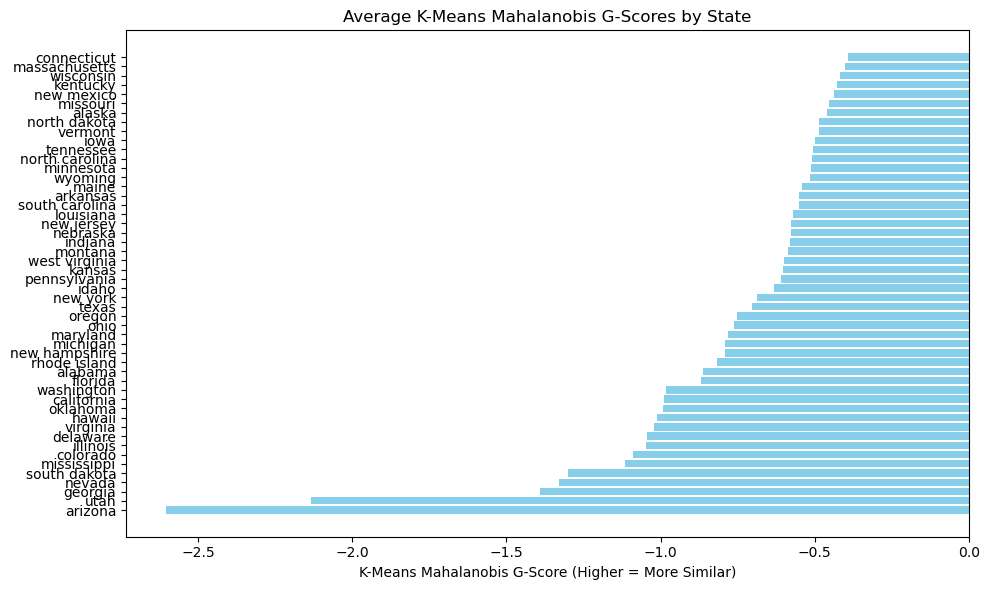

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the scores by State (averaging if there are duplicates)
grouped_scores = kmeans_mahalanobis_scores.groupby("State")["G_score"].mean().reset_index()

# Sort by score descending, so that the highest (i.e., least negative) scores are at the top.
grouped_scores.sort_values("G_score", ascending=False, inplace=True)

print("Grouped K-Means Mahalanobis G-Scores by State:")
print(grouped_scores.head(10))

# Create a horizontal bar plot to visualize the scores
plt.figure(figsize=(10, 6))
plt.barh(grouped_scores["State"], grouped_scores["G_score"], color='skyblue')
plt.xlabel("K-Means Mahalanobis G-Score (Higher = More Similar)")
plt.title("Average K-Means Mahalanobis G-Scores by State")
plt.gca().invert_yaxis()  # So that the state with the highest score appears at the top
plt.tight_layout()
plt.show()


Negative Distance as a Similarity Score

You see negative values because you used –(Euclidean distance). A value closer to zero (e.g., –0.2) indicates a smaller original distance to the cluster centroid, meaning that state is more representative (or “typical”) of its cluster.

Large negative values (like –2.5) mean that state is relatively far from the centroid, making it less typical within its group.

Plot Interpretation

States at the top of the chart (with more negative bars) have lower G-scores, meaning they deviate more from their cluster’s average. They’re effectively “outliers” or “less similar” to the cluster.

States at the bottom (bars near zero) are the most similar to their cluster centroid and thus are “typical” examples within that cluster’s baseline features.

Why This Matters

If you’re using these G-scores to pick a donor pool or do baseline grouping, states with higher (less-negative) G-scores are more “central” and can be considered good representatives of that cluster’s patterns.

Conversely, states with very negative G-scores might be outliers to treat separately or investigate further for unique economic structures.

Practical Takeaways

Connecticut, Massachusetts, Wisconsin, and Kentucky (among others at the top) are relatively far from their cluster centroids, so they might be outliers in terms of your baseline variables (asset_quality, profitability, high).

States lower on the chart (closer to zero) are more typical or standard within their clusters. If you’re selecting controls for a synthetic control analysis, these states might end up being more likely to match well with treated states in the same cluster.

In short, the bar chart visually shows each state’s “distance from average” within its cluster. Higher bars (less negative) = more representative states; lower bars (very negative) = more atypical states in the context of the baseline features you used.

In [ ]:
|